Датасет взят отсюда: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset?select=Vegetable+Images

In [1]:
# Для работы с EXIF-данными картинок
!pip install exif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 2.9 MB/s eta 0:00:00


In [2]:
import zipfile
import os

import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm.auto import tqdm
import seaborn as sns
import numpy as np
import cv2
import pandas as pd

# Для работы с EXIF-данными картинок
import exif

In [3]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    DRIVE_DIR = os.path.join("/content/drive", "MyDrive")
except ImportError:
    DRIVE_DIR = os.getcwd()

DATASET_DIR = os.path.join(os.getcwd(), "dataset", "Vegetable Images")
os.makedirs(DATASET_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Распаковка архива
with zipfile.ZipFile(os.path.join(DRIVE_DIR, "VegetableImages.zip"), "r") as zip_ref:
    zip_ref.extractall("./dataset")

# Проверим структуру папок
os.listdir(DATASET_DIR)

['Bitter_Gourd',
 'Potato',
 'Broccoli',
 'Tomato',
 'Pumpkin',
 'Bottle_Gourd',
 'Carrot',
 'Cucumber',
 'Papaya',
 'Radish',
 'Brinjal',
 'Capsicum',
 'Cabbage',
 'Bean',
 'Cauliflower']

In [5]:
# Список категорий
categories = os.listdir(DATASET_DIR)
category_counts = {
    category: len(os.listdir(os.path.join(DATASET_DIR, category))) for category in categories
}

print(f"Категории: {', '.join(categories)}")

Категории: Bitter_Gourd, Potato, Broccoli, Tomato, Pumpkin, Bottle_Gourd, Carrot, Cucumber, Papaya, Radish, Brinjal, Capsicum, Cabbage, Bean, Cauliflower


# 1. Анализ характеристик изображений

## Средние, минимальные и максимальные размеры изображений

In [6]:
# Функция для возврата списка строк вида [категория, имя файла, ширина, высота]
def check_image_sizes(folder_path, category):
    sizes = []
    for img in os.listdir(folder_path):
        image = Image.open(os.path.join(folder_path, img))
        sizes.append([category, img, *image.size])
    return sizes

In [7]:
# Соберу строки с инофрмацией о размерах, пройдясь по папкам категорий
row_list = []
for category in tqdm(categories):
    folder_path = os.path.join(DATASET_DIR, category)
    row_list.extend(check_image_sizes(folder_path, category))

print("Строки имеют вид:")
print(row_list[0])

  0%|          | 0/15 [00:00<?, ?it/s]

Строки имеют вид:
['Bitter_Gourd', '0847.jpg', 224, 224]


In [8]:
df = pd.DataFrame(row_list, columns=["category", "name", "width", "height"])
df.describe()

width        height
count  21000.0  21000.000000
mean     224.0    223.991333
std        0.0      0.467854
min      224.0    187.000000
25%      224.0    224.000000
50%      224.0    224.000000
75%      224.0    224.000000
max      224.0    224.000000

In [9]:
df["width"].unique(), df["height"].unique()

(array([224]), array([224, 205, 193, 200, 211, 187, 207, 223, 198, 210]))

In [10]:
df[df["height"] != 224]

category      name  width  height
153    Bitter_Gourd  0526.jpg    224     205
572    Bitter_Gourd  0430.jpg    224     193
605    Bitter_Gourd  0609.jpg    224     200
11227        Papaya  0126.jpg    224     211
11556        Papaya  1138.jpg    224     187
11613        Papaya  1246.jpg    224     207
11920        Papaya  1150.jpg    224     223
12105        Papaya  0176.jpg    224     198
12443        Papaya  0741.jpg    224     210

*Основная часть картинок размером 224 на 224 px, но встречаются картинки другого размера.*  
**Для ширины среднее значение, минимальное и максимальное совпадает - 224   
Для высоты среднее значение ~224, максимальное - 224, минимальное - 187**  
Присутствуют картинки с высотой другого размера в категории Papaya и Bitter_Gourd. Самая подходящая ширина и высота для картинок - **224x224px**

## Средние значения и отклонения по каналам (R, G, B)

In [11]:
# Функция для возврата списка строк вида [категория, имя файла, среднее отклонение rgb, стандартное отклонение rgb]
def check_image_color(folder_path, category):
    colors = []
    for img in os.listdir(folder_path):
        image = cv2.imread(os.path.join(folder_path, img))
        b, g, r = cv2.split(image)
        r_mean, g_mean, b_mean = np.mean(r), np.mean(g), np.mean(b)
        r_std, g_std, b_std = np.std(r), np.std(g), np.std(b)
        colors.append([category, img, r_mean, g_mean, b_mean, r_std, g_std, b_std])
    return colors

In [12]:
# Соберу строки с инофрмацией о RGB, пройдясь по папкам категорий
row_list = []
for category in tqdm(categories):
    folder_path = os.path.join(DATASET_DIR, category)
    row_list.extend(check_image_color(folder_path, category))

print("Строки имеют вид:")
print(row_list[0])

  0%|          | 0/15 [00:00<?, ?it/s]

Строки имеют вид:
['Bitter_Gourd', '0847.jpg', 93.02736367984694, 122.05729830994898, 44.909837372448976, 56.989502197891355, 61.63711328900292, 39.4651790926557]


In [13]:
rgb_df = pd.DataFrame(
    row_list, columns=["category", "name", "mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B"]
)
rgb_df.describe()

mean_R        mean_G        mean_B         std_R         std_G  \
count  21000.000000  21000.000000  21000.000000  21000.000000  21000.000000   
mean     119.337509    118.151408     87.348927     51.914656     52.396519   
std       27.391601     23.980795     33.588930     11.997966     10.794314   
min       45.794922     26.465840     11.900550     10.121523     12.691663   
25%       98.418253    106.007215     61.782501     46.314204     46.744917   
50%      114.738799    117.365055     82.310258     52.606615     53.218768   
75%      135.268495    130.212836    108.718416     58.575754     59.088941   
max      251.624821    251.437480    244.118324    109.484768    111.737861   

              std_B  
count  21000.000000  
mean      50.148858  
std       14.377823  
min       10.692505  
25%       40.683373  
50%       47.685299  
75%       56.861012  
max      119.839496

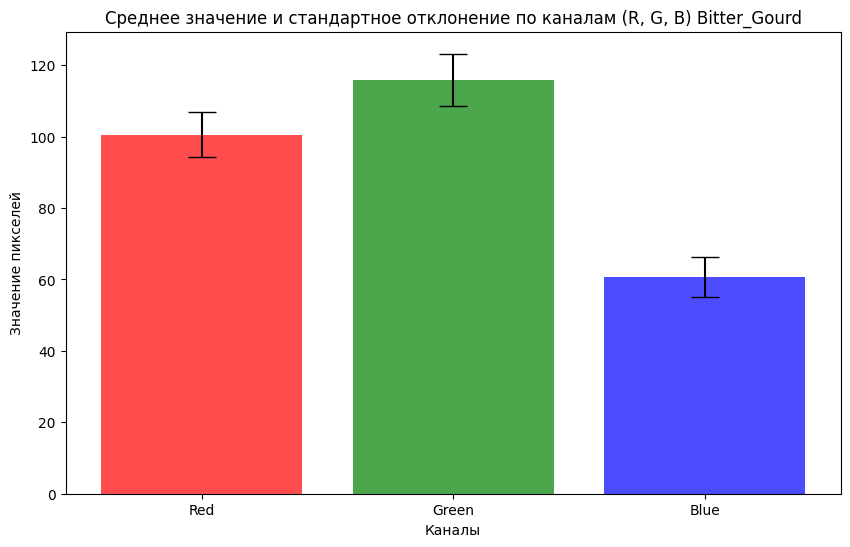

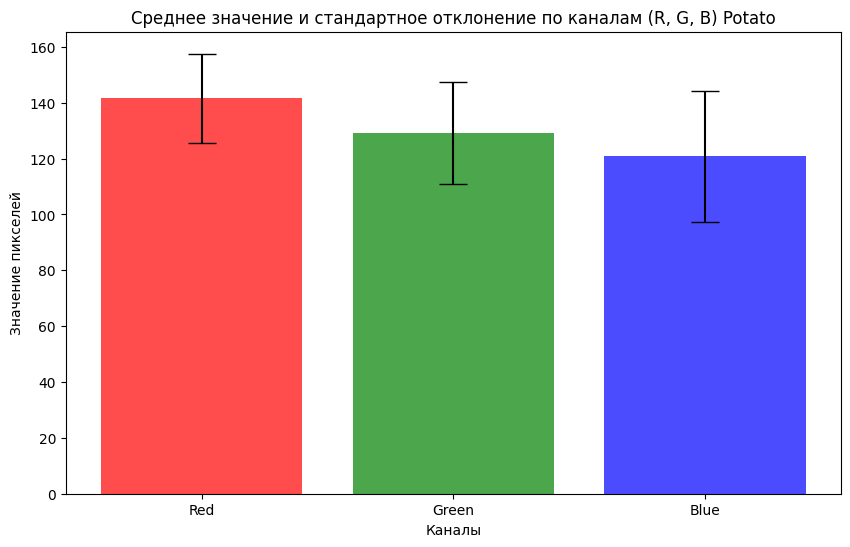

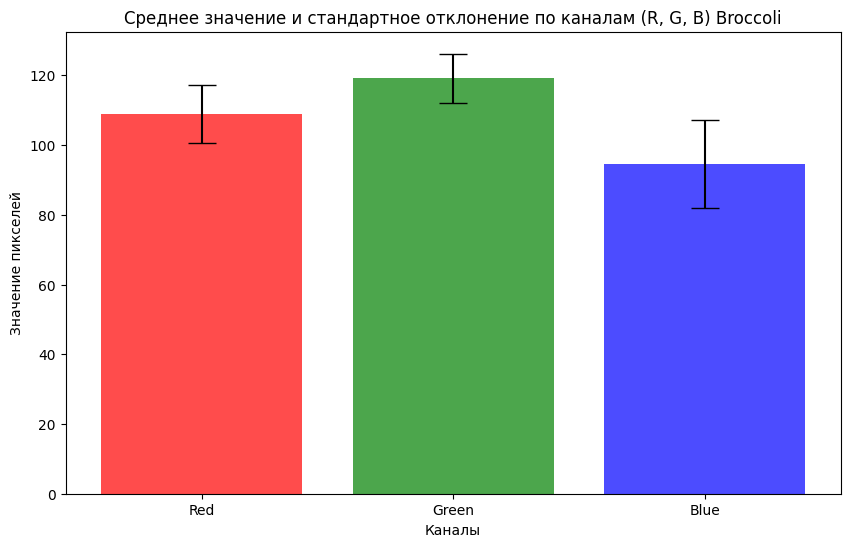

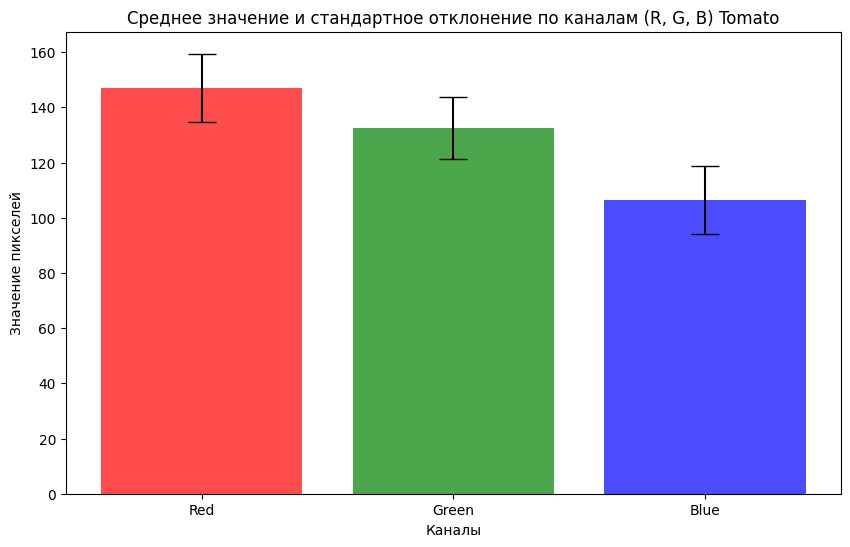

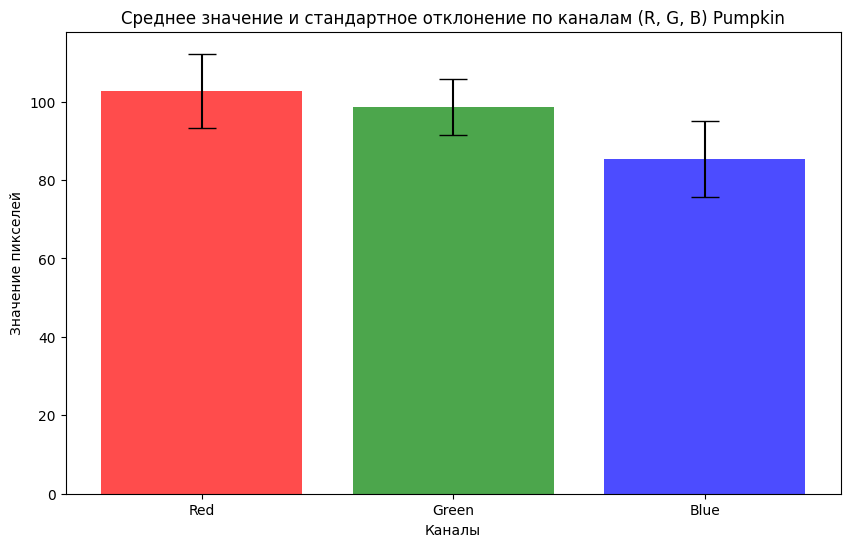

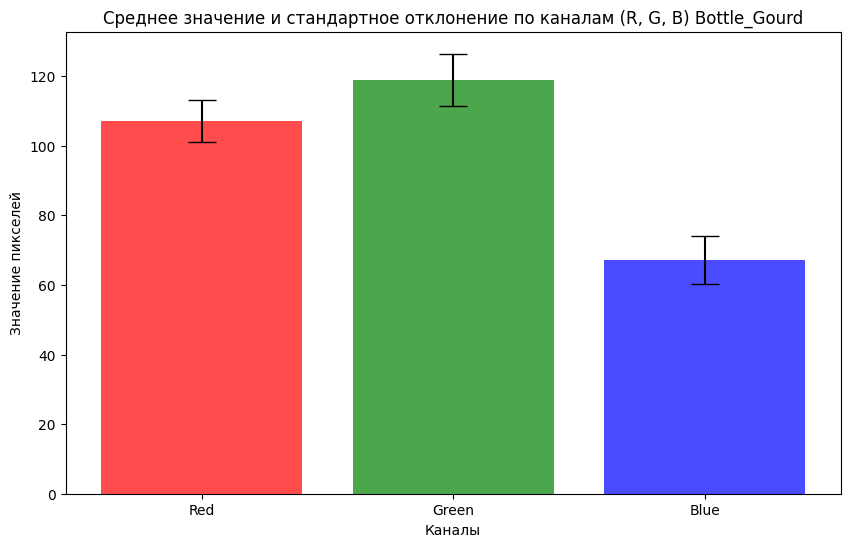

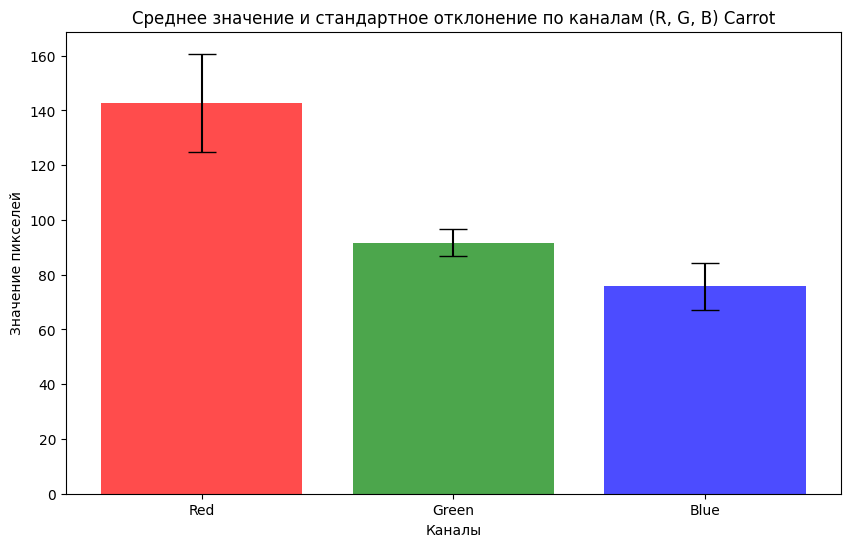

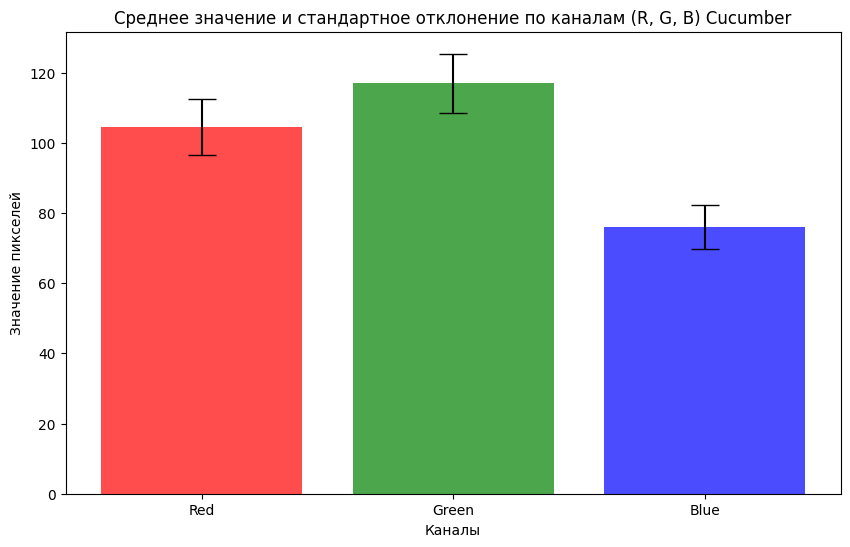

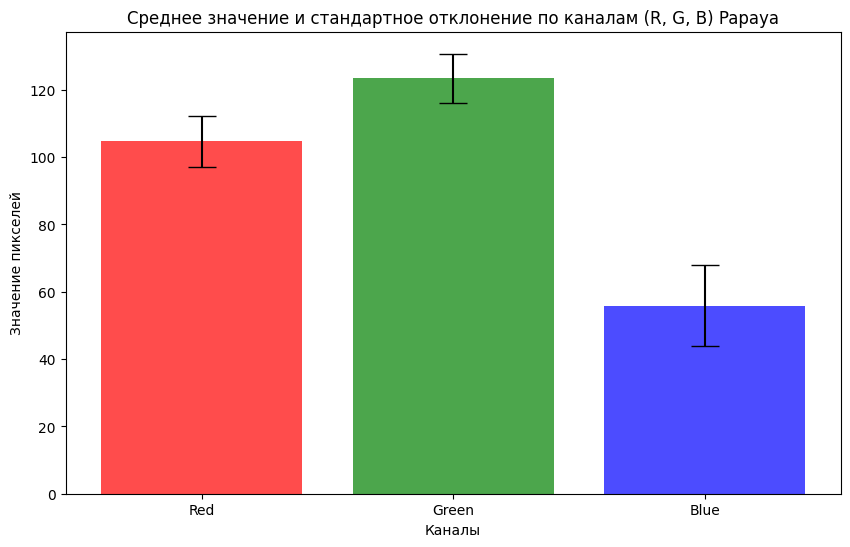

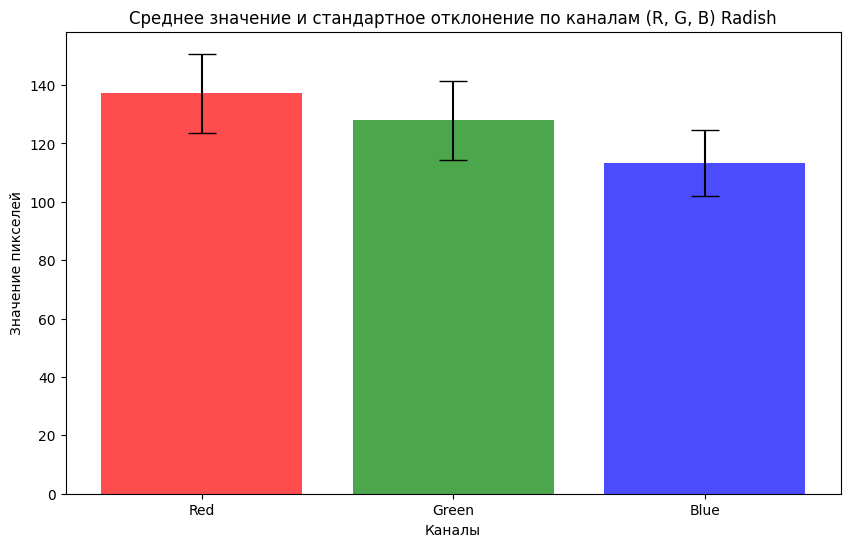

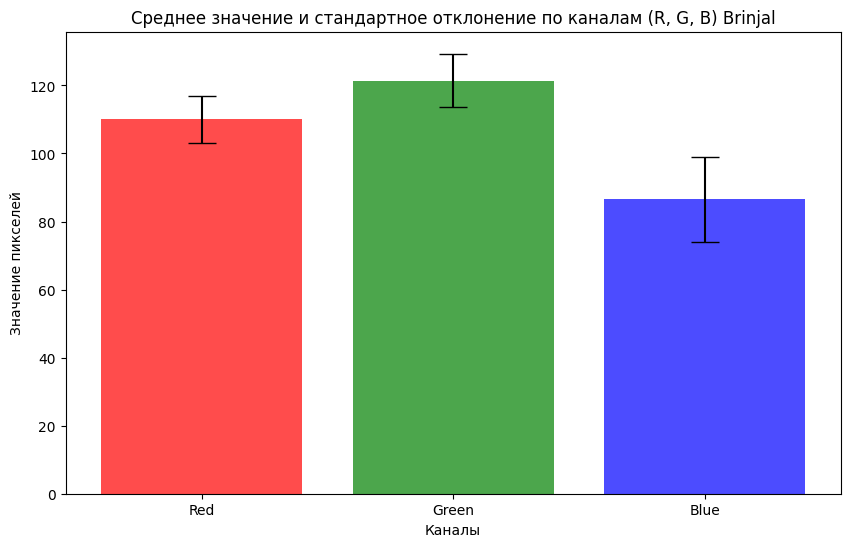

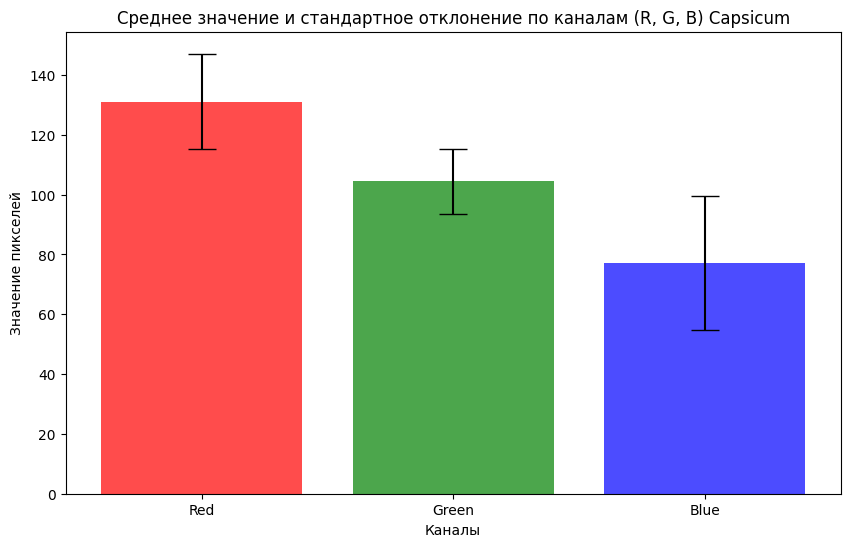

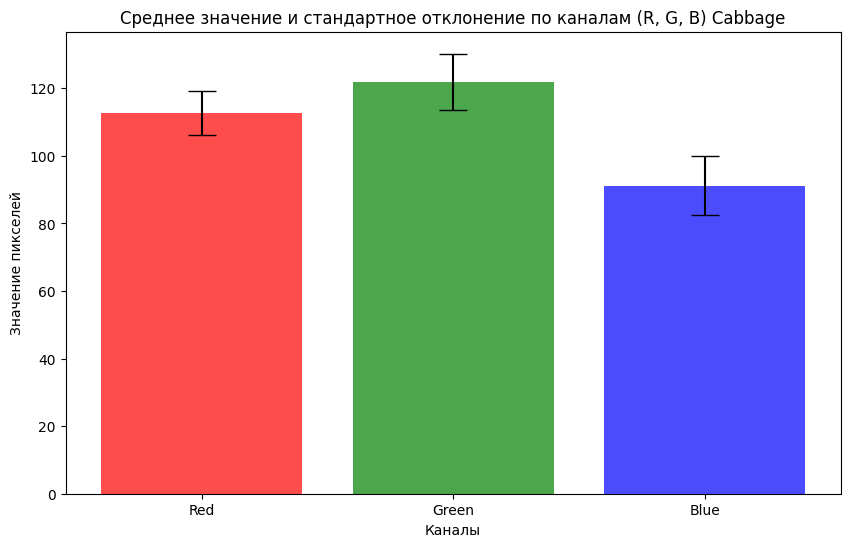

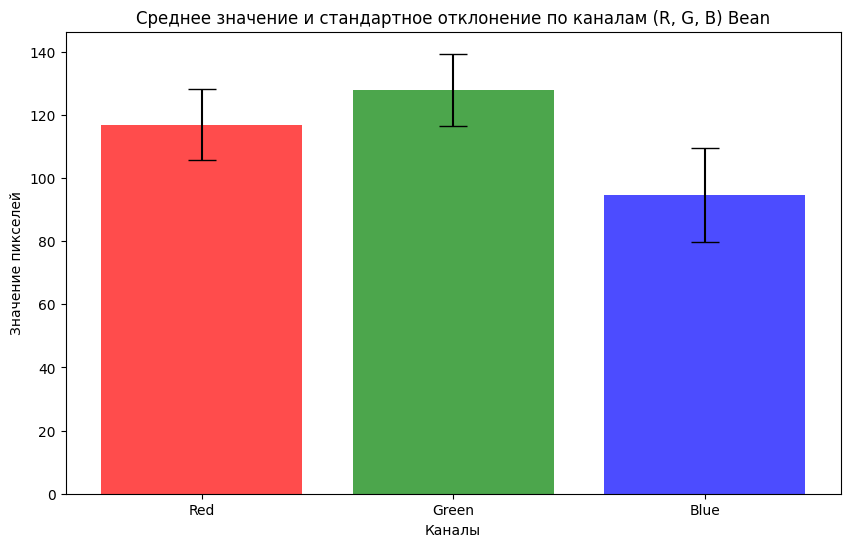

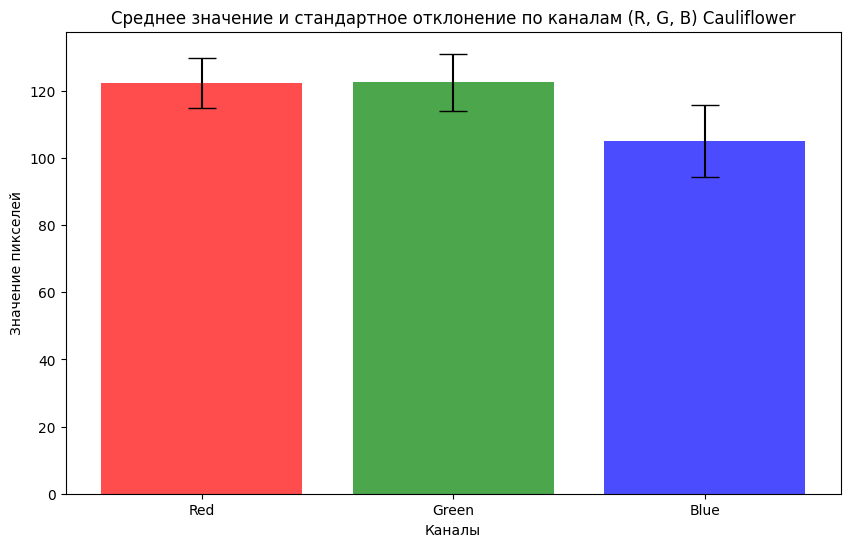

In [14]:
channels = ["Red", "Green", "Blue"]
for category in rgb_df["category"].unique():
    rows = rgb_df[rgb_df["category"] == category].values
    mean_r = np.mean(rows[:, 2])
    mean_g = np.mean(rows[:, 3])
    mean_b = np.mean(rows[:, 4])
    std_r = np.std(rows[:, 5])
    std_g = np.std(rows[:, 6])
    std_b = np.std(rows[:, 7])
    means = [mean_r, mean_g, mean_b]
    stds = [std_r, std_g, std_b]

    plt.figure(figsize=(10, 6))

    # Построим бар-график для среднего значения и стандартного отклонения
    plt.bar(channels, means, yerr=stds, capsize=10, color=["r", "g", "b"], alpha=0.7)

    plt.title(f"Среднее значение и стандартное отклонение по каналам (R, G, B) {category}")
    plt.ylabel("Значение пикселей")
    plt.xlabel("Каналы")
    plt.show()

# 2. Анализ метаданных изображений

In [15]:
# Вернет строки вида [категория, имя файла, модель фотоаппарата, значение диафрагмы, значение яркости, фокусное расстояние, коэф. цифрового масштабирования]
def check_exif_data(folder_path, category):
    exif_rows = []
    for img in os.listdir(folder_path):
        try:
            image = exif.Image(os.path.join(folder_path, img))
            if image.has_exif:
                # Добавляю модель фотоаппарата,
                exif_rows.append(
                    [
                        category,
                        img,
                        image.get("model"),
                        image.get("aperture_value"),
                        image.get("brightness_value"),
                        image.get("focal_length"),
                        image.get("digital_zoom_ratio"),
                    ]
                )
            else:
                exif_rows.append([category, img, None, None, None, None, None])
        except:
            print("Не удалось прочитать EXIF")
            exif_rows.append([category, img, None, None, None, None, None])
    return exif_rows

In [16]:
# Соберу строки с инофрмацией о EXIF, пройдясь по папкам категорий
exif_rows = []
for category in tqdm(categories):
    folder_path = os.path.join(DATASET_DIR, category)
    exif_rows.extend(check_exif_data(folder_path, category))

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/exif/_image.py:171: RuntimeWarning: ASCII tag contains 16 fewer bytes than specified
  retval = getattr(self, attribute)
/usr/local/lib/python3.10/dist-packages/exif/_app1_metadata.py:476: RuntimeWarning: skipping bad IFD 1
  warnings.warn(f"skipping bad IFD {ifd_key}", RuntimeWarning)


Не удалось прочитать EXIF
Не удалось прочитать EXIF
Не удалось прочитать EXIF
Не удалось прочитать EXIF
Не удалось прочитать EXIF


In [17]:
exif_df = pd.DataFrame(
    exif_rows,
    columns=[
        "category",
        "name",
        "model",
        "aperture_value",
        "brightness_value",
        "focal_length",
        "digital_zoom_ratio",
    ],
)

exif_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category            21000 non-null  object 
 1   name                21000 non-null  object 
 2   model               5186 non-null   object 
 3   aperture_value      5172 non-null   float64
 4   brightness_value    3416 non-null   float64
 5   focal_length        5185 non-null   float64
 6   digital_zoom_ratio  4050 non-null   float64
dtypes: float64(4), object(3)
memory usage: 1.1+ MB


In [18]:
exif_df.describe(include="all")

category      name     model  aperture_value  brightness_value  \
count          21000     21000      5186     5172.000000       3416.000000   
unique            15      1457        41             NaN               NaN   
top     Bitter_Gourd  0847.jpg  SM-A515F             NaN               NaN   
freq            1400        15      3490             NaN               NaN   
mean             NaN       NaN       NaN        2.052626          3.760876   
std              NaN       NaN       NaN        0.530380          4.553864   
min              NaN       NaN       NaN        1.610000         -6.340000   
25%              NaN       NaN       NaN        2.000000          0.230000   
50%              NaN       NaN       NaN        2.000000          4.045000   
75%              NaN       NaN       NaN        2.000000          6.680000   
max              NaN       NaN       NaN        8.918863         20.210000   

        focal_length  digital_zoom_ratio  
count    5185.000000         4050.000000  
unique           NaN                 NaN  
top              NaN                 NaN  
freq             NaN                 NaN  
mean        6.940258            0.948642  
std         6.917523            0.220754  
min         3.610000            0.000000  
25%         4.600000            1.000000  
50%         4.600000            1.000000  
75%         7.000000            1.000000  
max       105.000000            1.000000

**У некоторых картинок встречаются EXIF**, в дальнейшем их можно будет использовать как дополнительные признаки

# 3. Изучение связи изображений с целевой переменной

In [19]:
# Функция для отображения нескольких изображений из категории
def show_images(folder_path, category, num_images=5):
    image_files = random.sample(os.listdir(folder_path), num_images)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(image_files):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis("off")
    plt.show()

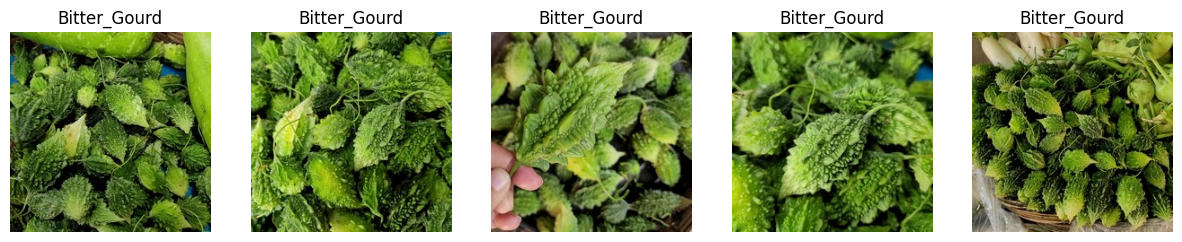

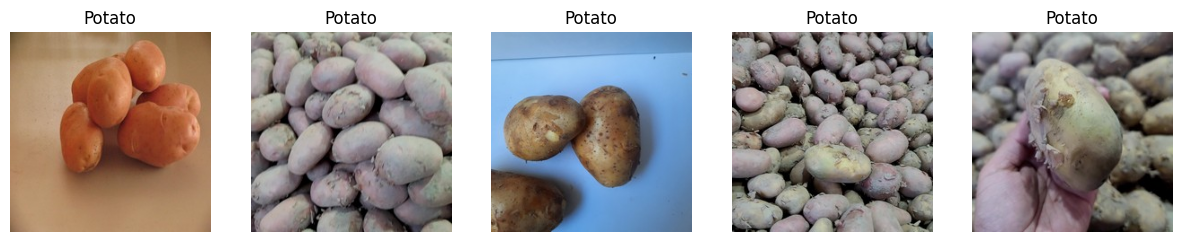

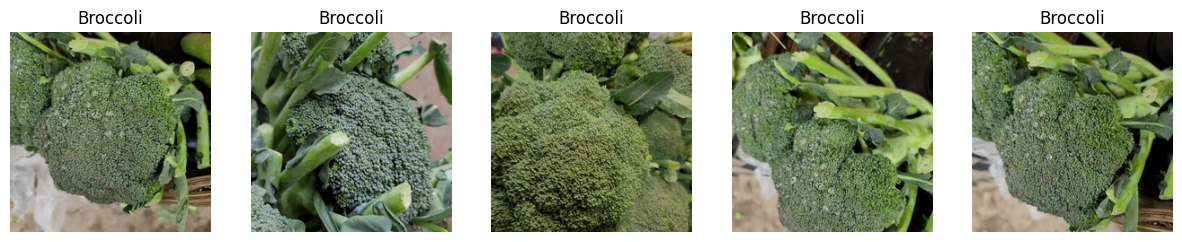

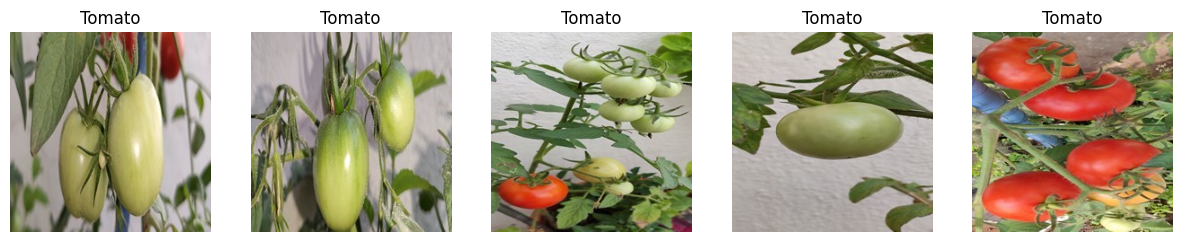

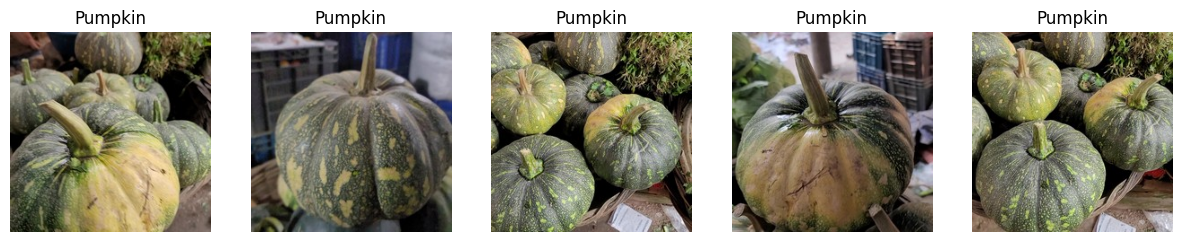

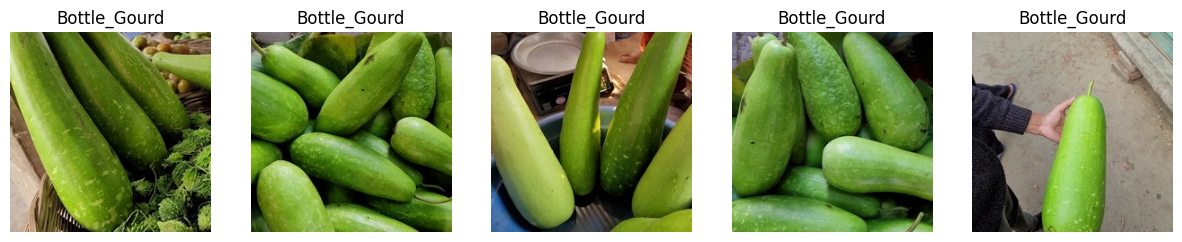

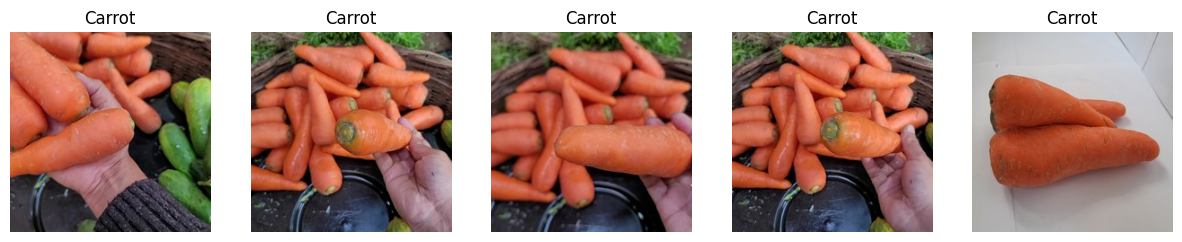

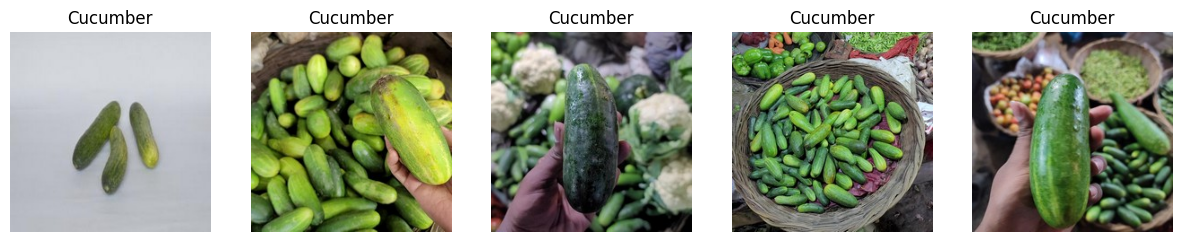

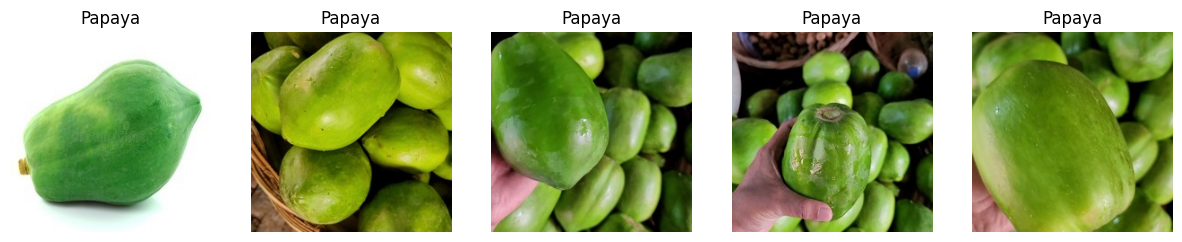

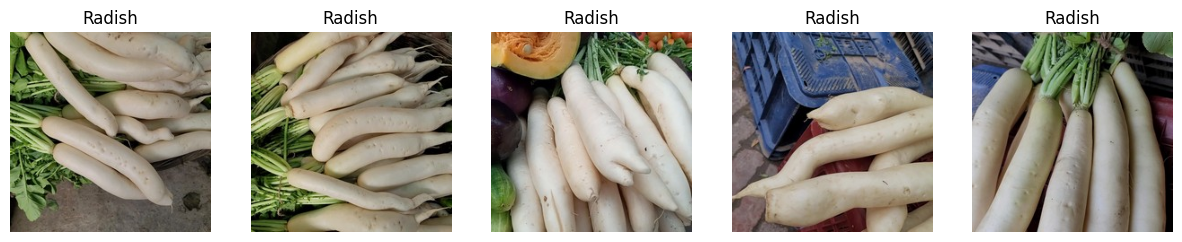

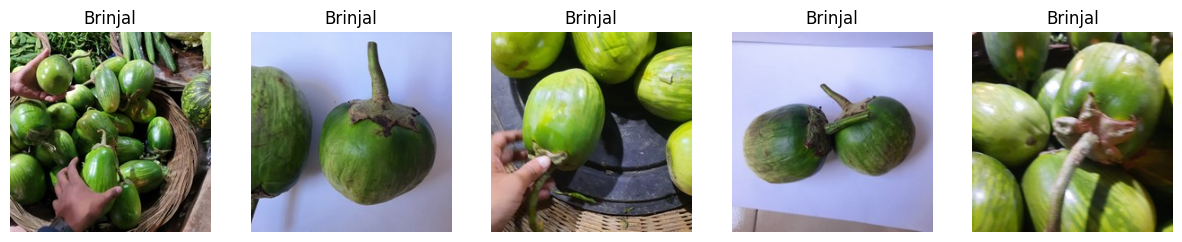

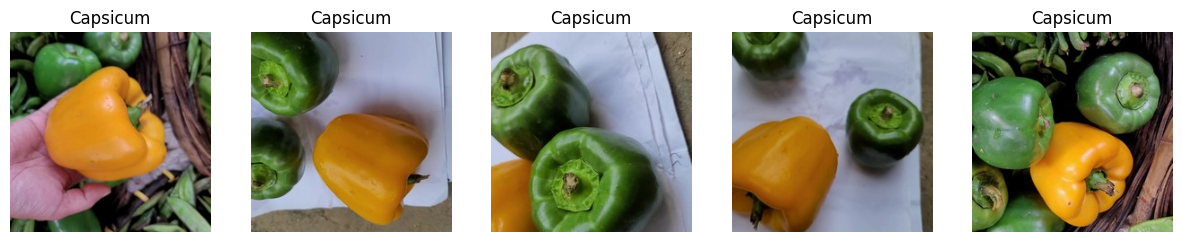

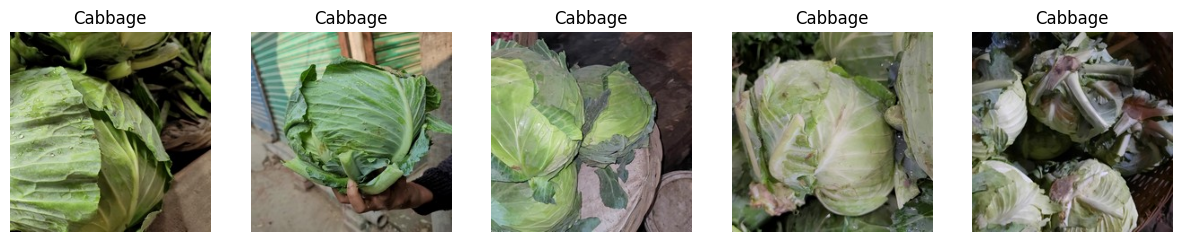

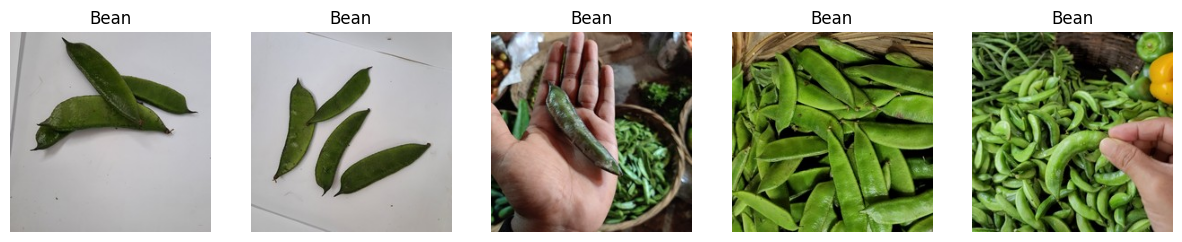

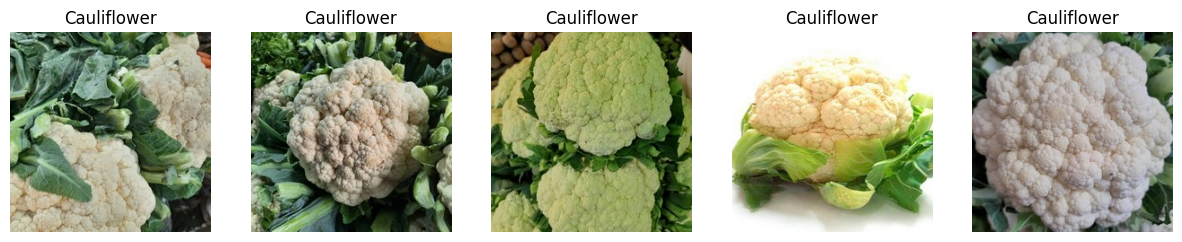

In [20]:
for category in categories:
    folder_path = os.path.join(DATASET_DIR, category)
    show_images(folder_path, category)

Для класса **Tomato**:  
Большая часть изображений в данном классе растянуты и сплюснуты.

Для класса **Radish**:  
Редис на изображениях светлый и вытянутый. Так же бывает круглый и красный редис, но в датасете такие не представлены

Для класса **Brinjal**:  
Все баклажаны в датасете зеленого цвета. Баклажаны чаще встречаются фиолетового цвета, в датасете не представлены.

Для класса **Pumpkin**:  
Тыквы в датасете все одинакового цвета, больше похожи на арбуз. Тыквы часто бывают рыжего цвета, но в датасете не представлены

Остальные классы в датасете выглядят удовлетворительно.

# 4. Визуализация данных

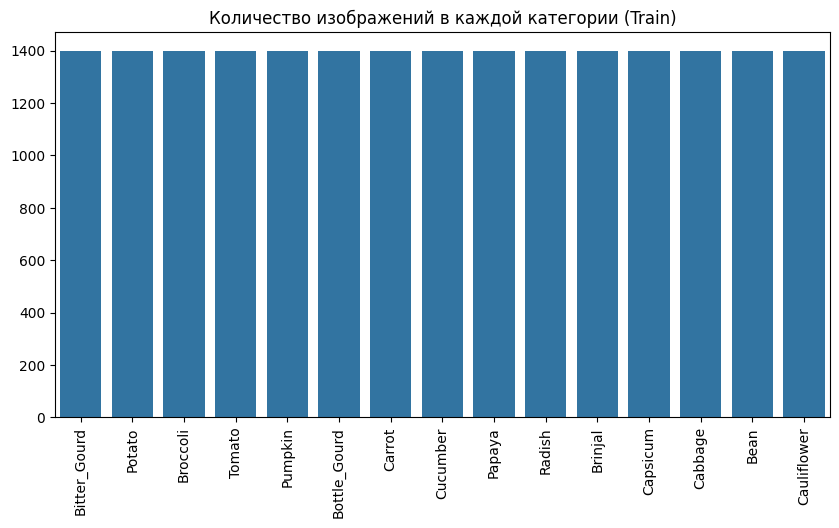

In [21]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xticks(rotation=90)
plt.title("Количество изображений в каждой категории (Train)")
plt.show()

Для каждой категории представлено 1400 изображений. Датасет хорошо сбалансирован.

# 5. Первичная предобработка изображений

## Определение размера для ресайза или нарезки изображений

In [22]:
# DataFrame с информацией о картинках с нестандартным размером
incorrect_sized = df.loc[(df["width"] != 224) | (df["height"] != 224)]
incorrect_sized.head()

category      name  width  height
153    Bitter_Gourd  0526.jpg    224     205
572    Bitter_Gourd  0430.jpg    224     193
605    Bitter_Gourd  0609.jpg    224     200
11227        Papaya  0126.jpg    224     211
11556        Papaya  1138.jpg    224     187

Т.к. есть изображения нестандартного размера, то можно привести их к одному размеру. Ранее было принято решение использовать оптимальный размер 224*224px.

In [23]:
def set_image_size(img_path: str, size: tuple[int, int]):
    image = Image.open(img_path)
    if image.size[0] != size[0] or image.size[1] != size[1]:
        resized_img = image.resize(size)
        resized_img.save(img_path)

In [24]:
for row in incorrect_sized.values:
    path = os.path.join(DATASET_DIR, row[0], row[1])
    set_image_size(path, (224, 224))

In [25]:
row_list = []
for category in tqdm(categories):
    folder_path = os.path.join(DATASET_DIR, category)
    row_list.extend(check_image_sizes(folder_path, category))

print(row_list[0])

  0%|          | 0/15 [00:00<?, ?it/s]

['Bitter_Gourd', '0847.jpg', 224, 224]


In [26]:
df = pd.DataFrame(row_list, columns=["category", "name", "width", "height"])
df.describe()

width   height
count  21000.0  21000.0
mean     224.0    224.0
std        0.0      0.0
min      224.0    224.0
25%      224.0    224.0
50%      224.0    224.0
75%      224.0    224.0
max      224.0    224.0